In [1]:
# Questi comandi permettono di usare in Jupyter le librerie di R presenti nel CRAN (Comprehensive R Archive Network)
country.code <- 'it'
url.pattern <- 'https://'  
repo.data.frame <- subset(getCRANmirrors(), CountryCode == country.code & grepl(url.pattern, URL))
options(repos = repo.data.frame$URL)

In [2]:
# Package utili: psych per le funzioni di stima dei parametri e readxl per poter leggere file excel
install.packages("psych")
install.packages("readxl")
install.packages("ltm")

package 'psych' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Marco\AppData\Local\Temp\Rtmpo5VuEM\downloaded_packages
package 'readxl' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Marco\AppData\Local\Temp\Rtmpo5VuEM\downloaded_packages
package 'ltm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Marco\AppData\Local\Temp\Rtmpo5VuEM\downloaded_packages


In [3]:
# Importo i package
library(psych)
library("readxl")
library("ltm")

Warning message:
"package 'psych' was built under R version 3.4.2"Warning message:
"package 'readxl' was built under R version 3.4.2"Warning message:
"package 'ltm' was built under R version 3.4.2"Loading required package: MASS
Loading required package: msm
Loading required package: polycor

Attaching package: 'polycor'

The following object is masked from 'package:psych':

    polyserial


Attaching package: 'ltm'

The following object is masked from 'package:psych':

    factor.scores



In [320]:
#' Legge un file csv e imposta la prima colonna con i nomi degli studenti come indici della tabella 
#'
#' @param path Percorso del file
#' @return data frame corrispondente al file csv indicato
#' @examples
#' readCSV("file.csv")
#'
#' readCSV("C:/Users/file.csv")
readCSV <- function(path) {
  read.csv(path, row.names = 1)
}

#' Legge un file excel e imposta la prima colonna con i nomi degli studenti come indici della tabella 
#'
#' @param path Percorso del file
#' @return data frame corrispondente al file excel indicato
#' @examples
#' readEXCEl("file.xlsx")
#'
#' readEXCEl("C:/Users/file.xlsx")
readEXCEl <- function(path) {
    items <- read_excel(path)
    items <- as.data.frame(items)
    rownames(items) <- items[,1]
    items <- items[,-1]
    items
}

In [513]:
# Importo la tabella dicotomica
datiDichot <- readEXCEl("EsameDic.xlsx")
datiDichot

,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10
S1,1,1,1,1,0,1,1,0,0,1
S2,1,0,1,1,0,0,1,1,0,0
S3,1,1,1,1,0,1,1,1,1,0
S4,1,1,1,1,1,1,1,1,1,0
S5,1,0,1,1,1,1,1,0,0,1
S6,0,1,1,1,1,0,0,1,1,0
S7,1,1,0,0,1,1,1,0,0,0
S8,1,1,1,1,0,1,1,1,1,1
S9,1,1,1,1,1,0,1,1,1,0
S10,0,0,1,1,1,0,0,1,0,1


In [435]:
#' Modifica la dimensione dei grafici
#'
#' @param width Larghezza dei grafici
#' @param height Altezza dei grafici
#' @examples
#' width <- 7
#' height <- 5
#' sizePlot(width, height)
sizePlot <- function(width, height) {
    options(repr.plot.width = width, repr.plot.height = height)
}

#' Stima le difficoltà degli esercizi senza porre vincoli sul valore del discriminante
#'
#' @param items Tabella dicotomica avente una riga per studente e una colonna per esercizio
#' @return Vettore di difficoltà stimate
#' @examples
#' items <- readEXCEl("file.xlsx")
#' estimateDifficultiesDichotFreeDiscrim(items)
estimateDifficultiesDichotFreeDiscrim <- function(items) {
    param <- rasch(items)
    tab <- coef(param)
    array(tab[,"Dffclt"])
}

#' Stima le difficoltà degli esercizi ponendo il discriminante ad 1
#'
#' @param items Tabella dicotomica avente una riga per studente e una colonna per esercizio
#' @return Vettore di difficoltà stimate
#' @examples
#' items <- readEXCEl("file.xlsx")
#' estimateDifficultiesDichotOneDiscrim(items)
estimateDifficultiesDichotOneDiscrim <- function(items) {
    param <- rasch(items, constraint = cbind(length(difficulties) + 1, 1))
    tab <- coef(param)
    array(tab[,"Dffclt"])
}

#' Genera un grafico per mostrare il livello di difficoltà di ciascun esercizio 
#'
#' @param items Tabella dicotomica avente una riga per studente e una colonna per esercizio
#' @param diff Vettore di difficoltà
#' @param color Colore del grafico, di default è rosso
#' @examples
#' items <- readEXCEl("file.xlsx")
#' diff <- estimateDifficultiesDichotOneDiscrim(items)
#' plotDifficultiesDichot(items, diff)
plotDifficultiesDichot <- function(items, diff, color = "red") {
    nItems <- length(diff)
    plot(diff,xlim=c(1,nItems),ylim=c(-5,5),type="b",main="Difficulties plot",xlab="Items",ylab="Difficulty",xaxt="n",col=color,pch=16,lwd=2)
    axis(1, at=1:nItems, labels=names(items))
    par(new = TRUE)
    plot(diff + 4.7, type = "h", xlim = c(1,nItems),ylim = c(0,10), xaxt='n', yaxt = "n", xlab = "", ylab = "", lty = 2)
}

#' Stima le abilità degli studenti
#'
#' @param items Tabella dicotomica avente una riga per studente e una colonna per esercizio
#' @return Vettore di abilità stimate
#' @examples
#' items <- readEXCEl("file.xlsx")
#' estimateAbilitiesDichot(items)
estimateAbilitiesDichot <- function(items) {
    info <- irt.0p(items) # <---------------------------------------------------- DA CAMBIARE
    info <- data.frame(info)
    info$theta0
}

#' Genera un istogramma per mostrare il livello di abilità degli studenti e la relativa quantità
#'
#' @param theta Vettore di abilità
#' @examples
#' items <- readEXCEl("file.xlsx")
#' abil <- estimateAbilitiesDichot(items)
#' plotDifficultiesDichot(abil)
plotAbilitiesDichot <- function(abil) {
    hist(abil,main="Ability histogram",xlab="Ability",ylab="Students",breaks=seq(-3,3,by=0.5),xlim=c(-3,3),col="royalblue3")
    axis(1, at=seq(-3, 3, by=0.5), labels=seq(-3, 3, by=0.5))        
}

In [436]:
#' Attraverso la tecnica di bootstrapping seleziona randomicamente n righe dalla matrice dicotomica, questa funzione è utlile 
#' se si dispone di pochi soggetti perchè in caso di una scarsa quantità di osservazioni lo stimatore potrebbe non covergere
#'
#' @param items Tabella dicotomica avente una riga per studente e una colonna per esercizio
#' @param n Numero di estrazioni
#' @return Data frame di difficoltà stimate dalla tabella generata dalle estrazioni casuali
#' @examples
#' items <- readEXCEl("file.xlsx")
#' bootstrapping(items)
bootstrapping <- function(items, n = 500) {
    idxs <- sample(1:nrow(items), n, replace = TRUE)
    items[idxs,]
}

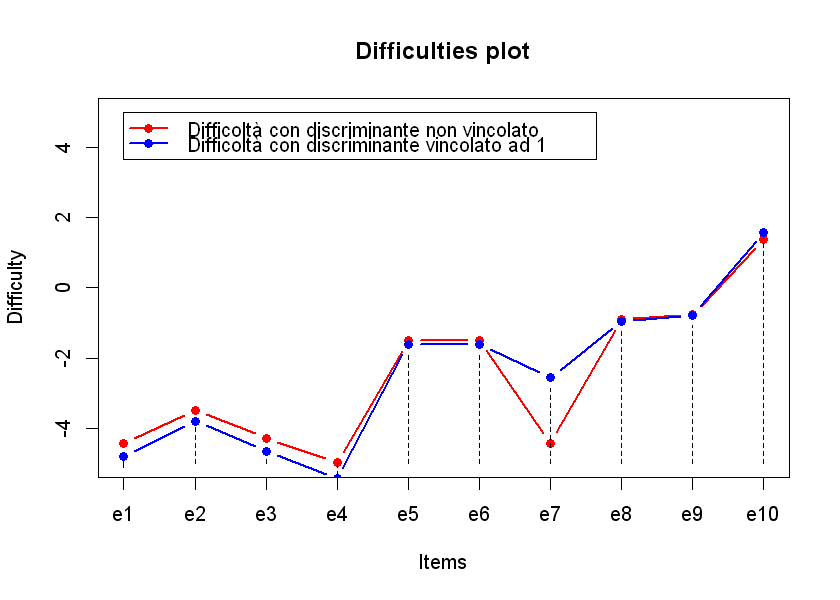

In [520]:
# Modifico la dimensione dei grafici
width <- 7
height <- 5
sizePlot(width, height)

# Effettuo il bootstrapping
numExtractions <- 700
bottDatiDichot <- bootstrapping(datiDichot, numExtractions)

# Stimo le difficoltà con entrambi i metodi
difficDichotF <- estimateDifficultiesDichotFreeDiscrim(bottDatiDichot)
difficDichotO <- estimateDifficultiesDichotOneDiscrim(bottDatiDichot)

# Visualizzo e confronto i grafici relativi alle difficoltà stimate con entrambi i metodi
plotDifficultiesDichot(datiDichot, difficDichotF)
par(new = TRUE)
plotDifficultiesDichot(datiDichot, difficDichotO, color = "blue")
legend(1, 10, legend=c("Difficoltà con discriminante non vincolato", "Difficoltà con discriminante vincolato ad 1"), col=c("red", "blue"), lty=1, cex=1, lwd=2, pch=16)

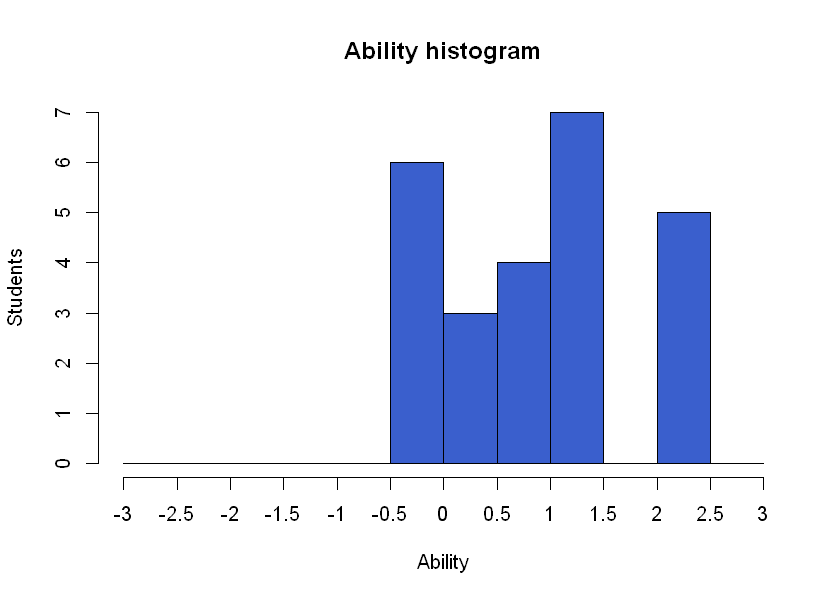

In [522]:
# Stimo le abilità e visualizzo il relativo grafico
abil   <- estimateAbilitiesDichot(datiDichot)
plotAbilitiesDichot(abil)

In [443]:
#' Calcola la probabilità che uno studente risolva correttamente un esercizio
#'
#' @param ability Abilità dello studente
#' @param difficulty Difficoltà dell'esercizio
#' @return Probabilità di rispondere correttamente, compresa tra 0 e 1
#' @examples
#' ability <- 2
#' difficulty <- 1
#' pl1(ability, difficulty)
pl1 <- function(ability, difficulty) {
    exp(ability - difficulty) / (1 + exp(ability - difficulty))
}

#' Determina la probabilità per ogni studente di risolvere correttamente ogni esercizio
#'
#' @param items Tabella dicotomica avente una riga per studente e una colonna per esercizio
#' @param diff Vettore di difficoltà
#' @param abil Vettore di abilità
#' @return Data frame di probabilità
#' @examples
#' items <- readEXCEl("file.xlsx")
#' diff <- estimateDifficultiesDichotFreeDiscrim(items)
#' abil <- estimateAbilitiesDichot(items)
#' calcProbabilites(items, diff, abil)
calcProbabilites <- function(items, diff, abil) {   
    probDf <- items
    namesCol <- names(probDf)
    namesRow <- row.names(probDf)
    j <- 1
    for (row in namesRow) {
        i <- 1
        for (col in namesCol) {
            prob <- pl1(abil[j],diff[i])
            probDf[row,col] <- prob          
            i <- i + 1
        }
        j <- j + 1
    }
    probDf
}


#' Migliora la lettura della tabella delle probabilità per l'utente
#'
#' @param df Data frame di probabilità, output della funzione calcProbabilites
#' @return Data frame di probabilità da 0 a 100
#' @examples
#' items <- readEXCEl("file.xlsx")
#' diff <- estimateDifficultiesDichotFreeDiscrim(items)
#' abil <- estimateAbilitiesDichot(items)
#' dfProb <- calcProbabilites(items, diff, abil)
#' showProbabilities(dfProb)
showProbabilities <- function(df){
    aux <- trunc(df*100)
    aux <- data.frame(lapply(aux, function(p) paste(p, "%")))
    row.names(aux) <- row.names(df)
    aux
}

In [524]:
# Calcolo la tabella di probabilità che ogni studente risponda correttamente ad ogni test
dfP <- calcProbabilites(datiDichot, difficDichot, abil)

# Visualizzo la tabella più semplicemente
showProbabilities(dfP)

,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10
S1,99 %,98 %,99 %,99 %,93 %,89 %,99 %,89 %,78 %,37 %
S2,99 %,96 %,98 %,99 %,86 %,79 %,99 %,78 %,60 %,20 %
S3,99 %,99 %,99 %,99 %,96 %,93 %,99 %,93 %,85 %,50 %
S4,99 %,99 %,99 %,99 %,98 %,97 %,99 %,96 %,93 %,69 %
S5,99 %,98 %,99 %,99 %,93 %,89 %,99 %,89 %,78 %,37 %
S6,99 %,97 %,99 %,99 %,90 %,85 %,99 %,84 %,69 %,27 %
S7,99 %,96 %,98 %,99 %,86 %,79 %,99 %,78 %,60 %,20 %
S8,99 %,99 %,99 %,99 %,98 %,97 %,99 %,96 %,93 %,69 %
S9,99 %,99 %,99 %,99 %,96 %,93 %,99 %,93 %,85 %,50 %
S10,99 %,96 %,98 %,99 %,86 %,79 %,99 %,78 %,60 %,20 %


In [525]:
#' Genera una tabella dicotomica
#'
#' @param diff vettore di difficoltà scelte
#' @param abil vettore di abilità scelte
#' @return La tabella dicotomica generata
#' @examples
#' numItems <- 10
#' numStudents <- 30
#' diffInit <- rnorm(numItems)
#' abil <- rnorm(numStudents)
#' generateDichot(diffInit, abil)
generateDichot <- function(diff, abil) {
    items <- data.frame(matrix(0, ncol = length(diff), nrow = length(abil)))
    prob <- calcProbabilites(items, diff, abil)

    namesCol  <- names(items)
    namesRow  <- row.names(items)
    for (row in namesRow) {
        for (col in namesCol) {
            items[row,col] <- rbinom(1, 1, prob[row,col])         
        }
    }
    
    items
}

#' Valuta la bontà del mio stimatore misurando lo scostamento tra le difficoltà passate per argomento
#'
#' @param diff1 vettore di difficoltà 
#' @param diff2 vettore di difficoltà 
#' @return Data frame con le difficoltà passate per argomento e lo scostamento rilevato
#' @examples
#' numItems <- 10
#' numStudents <- 30
#' bootStrapVal <- 10
#' diffInit <- rnorm(numItems)
#' abil <- rnorm(numStudents)
#' genDic <- generateDichot(diffInit, abil)
#' genDicBoot <- bootstrapping(genDic, numStudents * bootStrapVal)
#' diffEstim <- estimateDifficultiesDichotFreeDiscrim(genDicBoot)
#' validationWithDifference(diffInit, diffEstim)
validationWithDifference <- function(diff1, diff2) { 
    scost <- abs(unlist(lapply(diff1 - diff2 , round, 2)))
    compare <- data.frame(diff1, diff2, scost)   
    colnames(compare) <- c("Difficoltà 1","Difficoltà 2", "Scostamento")
    compare
}

#' Valuta la bontà del mio stimatore confrontando graficamente le difficoltà passate per argomento
#'
#' @param diff1 vettore di difficoltà 
#' @param diff2 vettore di difficoltà 
#' @examples
#' numItems <- 10
#' numStudents <- 30
#' bootStrapVal <- 10
#' diffInit <- rnorm(numItems)
#' abil <- rnorm(numStudents)
#' genDic <- generateDichot(diff, abil)
#' genDicBoot <- bootstrapping(genDic, numStudents * bootStrapVal)
#' diffEstim <- estimateDifficultiesDichotFreeDiscrim(genDicBoot)
#' validationWithPlot(diffInit, diffEstim)
validationWithPlot <- function(diff1, diff2) {
    plot(diff1,xlim=c(1,length(diff1)),ylim=c(-4,4),type="b",main="Comparison plot",xlab="Items",ylab="Difficulty",xaxt="n",col="red",pch=16,lwd=2)
    axis(1, at = 1:length(diff1), labels = 1:length(diff1))
    par(new = TRUE)
    plot(diff2, type = "b", xlim = c(1,length(diff2)),ylim = c(-4,4), xaxt='n', yaxt = "n", xlab = "", ylab = "", col = "blue", pch=16, lwd=2)
    legend(1, 3, legend=c("Difficoltà 1", "Difficoltà 2"), col=c("red", "blue"), lty=1, cex=1, lwd=2, pch=16)
}

#' Valuta la bontà del mio stimatore calcolando il coefficiente di correlazione lineare
#'
#' @param diff1 vettore di difficoltà 
#' @param diff2 vettore di difficoltà 
#' @return Valore numerico compreso tra -1 e 1: se si avvicina a -1 i dati sono correlati negativamente, se si avvicina ad 1 
#' i dati sono correlati positivamente e se è un valore vicino a 0 allora non vi è alcun tipo di correlazione lineare
#' @examples
#' numItems <- 10
#' numStudents <- 30
#' bootStrapVal <- 10
#' diffInit <- rnorm(numItems)
#' abil <- rnorm(numStudents)
#' genDic <- generateDichot(diff, abil)
#' genDicBoot <- bootstrapping(genDic, numStudents * bootStrapVal)
#' diffEstim <- estimateDifficultiesDichotFreeDiscrim(genDicBoot)
#' validationWithCor(diffInit, diffEstim)
validationWithCor <- function(diff1, diff2) {
    cor(diff1, diff2)
}

In [531]:
# Definisco il numero di items, il numero di studenti ed quante estrazioni effettuare rispetto al numero di studenti
numItems <- 10
numStudents <- 40 
bootStrapVal <- 15

# Genero randomicamente difficolà e abilità
diff <- rnorm(numItems)
abil <- rnorm(numStudents)

# Genero la tabella dicotomica e vi applico il bootstrapping
genDic <- generateDichot(diff, abil)
genDicBoot <- bootstrapping(genDic, numStudents * bootStrapVal)

# Stimo le difficoltà con entrambi i metodi
esDiffO <- estimateDifficultiesDichotOneDiscrim(genDic)
esDiffF <- estimateDifficultiesDichotFreeDiscrim(genDic)

Difficoltà 1,Difficoltà 2,Scostamento
-0.55696983,-0.57634134,0.02
-0.13019571,-0.18764663,0.06
0.12731031,0.01159023,0.12
-0.03164476,-0.28556261,0.25
-0.33587580,-0.57631528,0.24
1.86561664,1.46368008,0.40
0.28235478,-0.73352412,1.02
0.46047473,0.32772767,0.13
-2.26400157,-2.37093548,0.11
2.62241187,1.46341423,1.16


[1] "Coefficiente di correlazione lineare: 0.959848134894924"

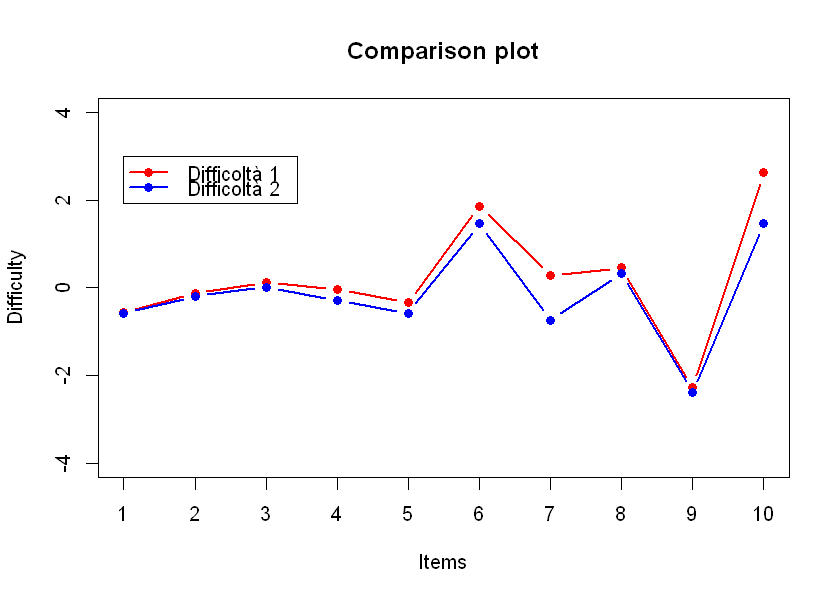

In [535]:
# Confronto le difficoltà iniziali e quelle stimate fissando il discriminante ad 1
validationWithDifference(diff, esDiffO)
validationWithPlot(diff, esDiffO)
paste("Coefficiente di correlazione lineare:",validationWithCor(diff, esDiffO))

Difficoltà 1,Difficoltà 2,Scostamento
-0.55696983,-0.2358703,0.32
-0.13019571,0.2092851,0.34
0.12731031,0.4367999,0.31
-0.03164476,0.0974592,0.13
-0.33587580,-0.2359471,0.10
1.86561664,2.0883806,0.22
0.28235478,0.7967764,0.51
0.46047473,0.7967801,0.34
-2.26400157,-2.3166980,0.05
2.62241187,2.0882877,0.53


[1] "Coefficiente di correlazione lineare: 0.975579743682003"

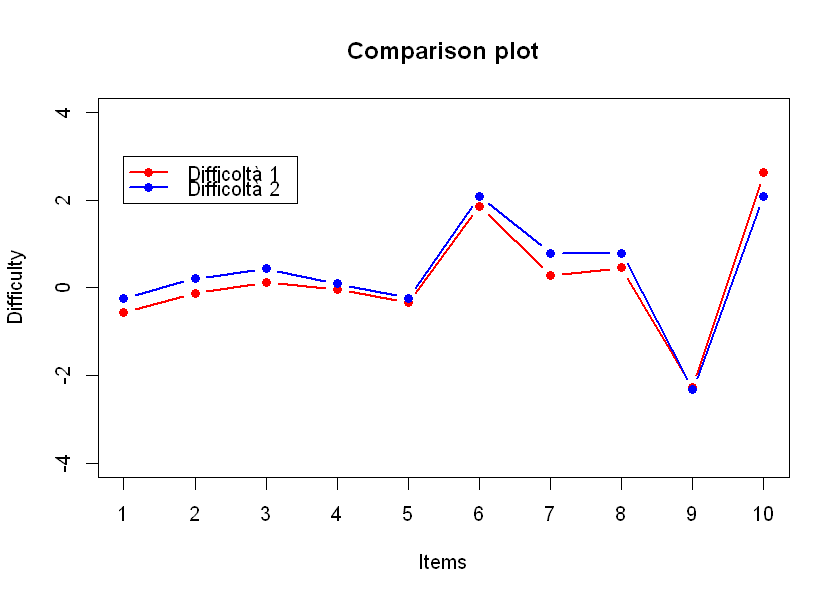

In [536]:
# Confronto le difficoltà iniziali e quelle stimate senza fissare il discriminante
validationWithDifference(diff, esDiffF)
validationWithPlot(diff, esDiffF)
paste("Coefficiente di correlazione lineare:",validationWithCor(diff, esDiffF))

Difficoltà 1,Difficoltà 2,Scostamento
-0.2358703,-0.57634134,0.34
0.2092851,-0.18764663,0.40
0.4367999,0.01159023,0.43
0.0974592,-0.28556261,0.38
-0.2359471,-0.57631528,0.34
2.0883806,1.46368008,0.62
0.7967764,-0.73352412,1.53
0.7967801,0.32772767,0.47
-2.3166980,-2.37093548,0.05
2.0882877,1.46341423,0.62


[1] "Coefficiente di correlazione lineare: 0.953789844059772"

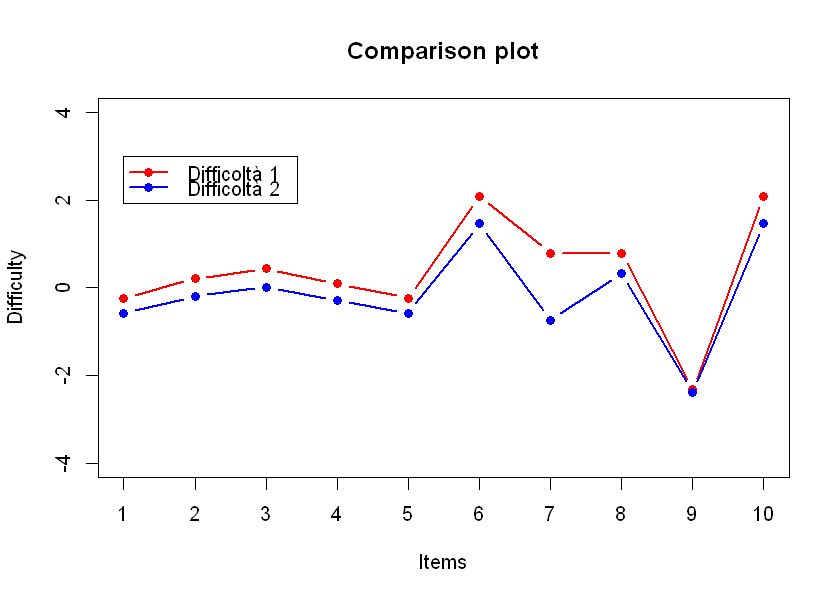

In [537]:
# Confronto le difficoltà stimate fissando il discriminante ad 1 con quelle stimate senza fissarlo
validationWithDifference(esDiffF, esDiffO)
validationWithPlot(esDiffF, esDiffO)
paste("Coefficiente di correlazione lineare:",validationWithCor(esDiffF, esDiffO))